In [1]:
# import tarfile

# for i in range(1,4):
#     with tarfile.open(f'part{i}.tar.gz', 'r:gz') as tar:
#         tar.extractall(path='./dataset/') 


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,TensorDataset,Dataset
import os
from PIL import Image
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
])

In [4]:
# age_class = []
# gender = []
# ethinicity = []
# images =[]

# folders = os.listdir("./dataset")

# for folder in folders:
#     for image in os.listdir(os.path.join("./dataset",folder)):
#         data = image.split("_")
#         if(len(data)==4 and ('' not in data)):        
#             image = Image.open(f"./dataset/{folder}/{image}").convert('RGB')  
#             tensor = transform(image)
#             images.append(tensor)
#             age,gen,eth = data[:-1]
#             age_class.append(int(age)//5)
#             gender.append(int(gen))
#             ethinicity.append(int(eth))

# print(set(age_class))
# print(set(gender))
# print(set(ethinicity))

In [5]:
z_dim = 100
epochs = 50
lr= 2e-4
img_channels = 3
img_height = 64
img_width = 64
batch_size = 64
conditional_length = 31
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# class CustomDataset(Dataset):
#     def __init__(self, images, labels):
#         self.images = images
#         self.labels = labels

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         return self.images[idx], self.labels[idx]

# labels = torch.tensor(list(zip(age_class, gender, ethinicity)))

# dataset = CustomDataset(images=torch.stack(images), labels=labels)

# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# for batch in dataloader:
#     image_batch, label_batch = batch
#     print("Image batch shape:", image_batch.shape)  
#     print("Label batch shape:", label_batch.shape)  
#     break

In [7]:
# batches = []
# for batch_idx, (image, label) in enumerate(dataloader):
#     batches.append((image, label))

# # Save to a file
# torch.save(batches, 'batches.pth')

# # Load the batches later
# loaded_batches = torch.load('batches.pth')

In [8]:
loaded_batches = torch.load('batches.pth')
for batch in loaded_batches:
    image_batch, label_batch = batch
    print("Image batch shape:", image_batch.shape)  
    print("Label batch shape:", label_batch.shape)  
    break

C:\Users\LEGION\AppData\Local\Temp\ipykernel_22200\2368217014.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_batches = torch.load('batches.pth')


Image batch shape: torch.Size([64, 3, 64, 64])
Label batch shape: torch.Size([64, 3])


In [9]:
print(len(loaded_batches))

377


In [10]:
class Generator(nn.Module):
    def __init__(self, z_dim , conditional_length):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim + conditional_length,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024,img_height*img_width*img_channels),
            nn.Tanh()
        )
    
    def forward(self,noise,labels):
        x = torch.cat([noise,labels],dim=1)
        img = self.gen(x)
        return img.view(labels.size(0),img_channels,img_height,img_width)

In [11]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, conditional_length):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels + conditional_length, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        # print(labels.shape)
        labels = labels.view(labels.size(0), -1, 1, 1)
        # print(labels.shape)
        labels = labels.repeat(1, 1, img.size(2), img.size(3))
        # print(labels.shape)
        x = torch.cat([img, labels], dim=1)
        # print("X = ",x.shape)
        return self.disc(x)



In [12]:
generator = Generator(z_dim=z_dim,
                      conditional_length=conditional_length,
                      ).to(device)

discriminator = Discriminator(img_channels=img_channels,
                              conditional_length=conditional_length).to(device)

In [13]:
optim_gen = optim.Adam(params=generator.parameters(),lr=lr,  betas=(0.5,0.999))
optim_disc = optim.Adam(params=discriminator.parameters(),lr=lr,  betas=(0.5,0.999))
criterion = nn.BCELoss()

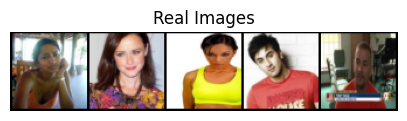

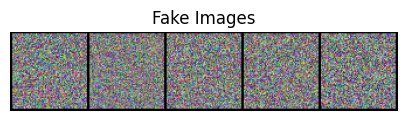

Epoch [1/50] | D Loss: 0.8642808198928833 | G Loss: 2.4535369873046875


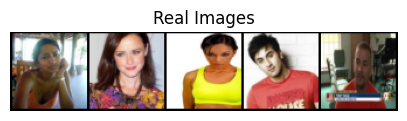

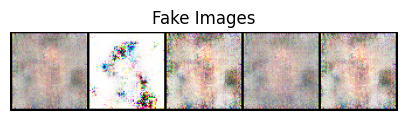

Epoch [2/50] | D Loss: 0.13473258912563324 | G Loss: 2.65547513961792


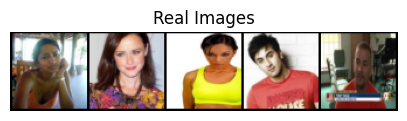

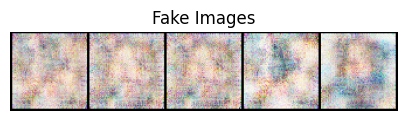

Epoch [3/50] | D Loss: 0.01694897934794426 | G Loss: 4.923979759216309


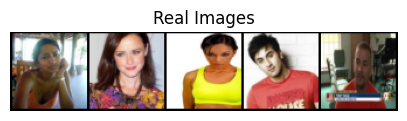

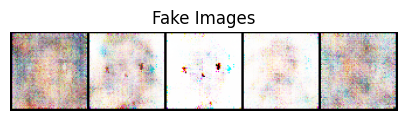

Epoch [4/50] | D Loss: 0.005214793141931295 | G Loss: 12.392766952514648


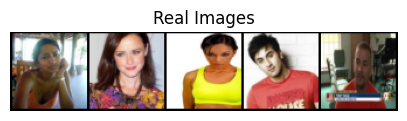

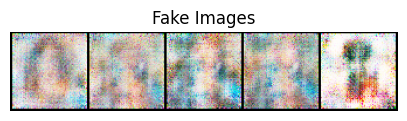

Epoch [5/50] | D Loss: 0.18397477269172668 | G Loss: 3.677133560180664


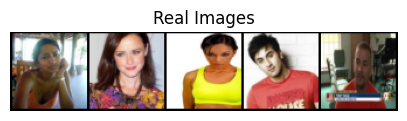

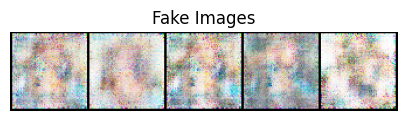

Epoch [6/50] | D Loss: 0.0019268944161012769 | G Loss: 9.724924087524414


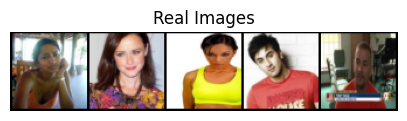

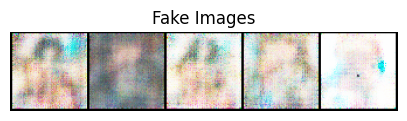

Epoch [7/50] | D Loss: 0.011242239736020565 | G Loss: 5.096773147583008


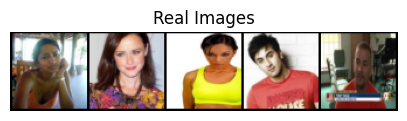

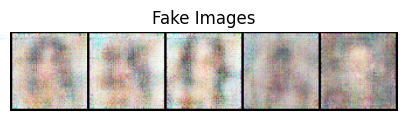

Epoch [8/50] | D Loss: 0.0005459811654873192 | G Loss: 11.168365478515625


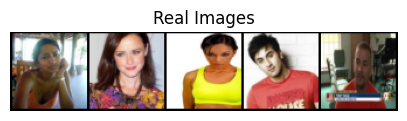

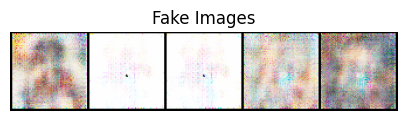

Epoch [9/50] | D Loss: 0.00033614604035392404 | G Loss: 10.772872924804688


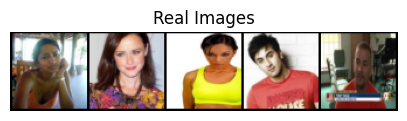

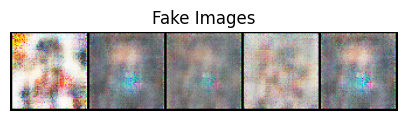

Epoch [10/50] | D Loss: 0.00010219456453341991 | G Loss: 13.027978897094727


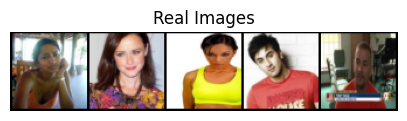

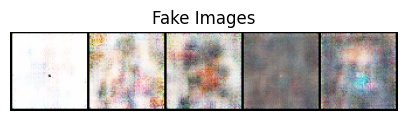

Epoch [11/50] | D Loss: 0.08307531476020813 | G Loss: 3.1939923763275146


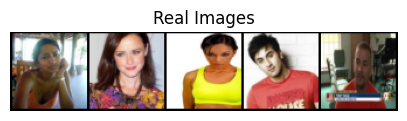

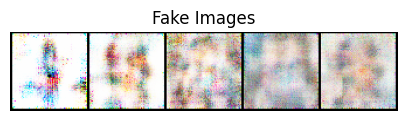

Epoch [12/50] | D Loss: 0.05314250662922859 | G Loss: 3.555950164794922


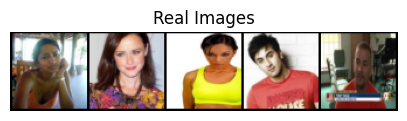

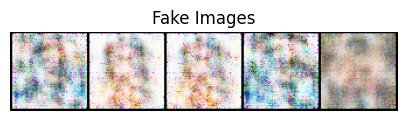

Epoch [13/50] | D Loss: 0.04967449977993965 | G Loss: 3.703350067138672


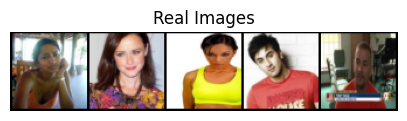

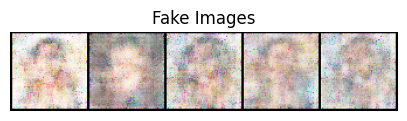

Epoch [14/50] | D Loss: 0.05051825940608978 | G Loss: 4.0286431312561035


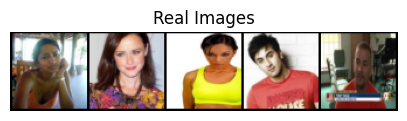

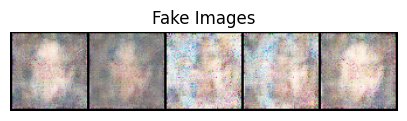

Epoch [15/50] | D Loss: 0.09541361033916473 | G Loss: 3.7103283405303955


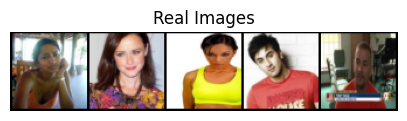

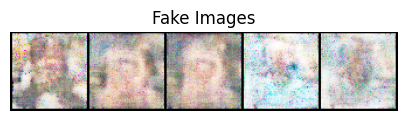

Epoch [16/50] | D Loss: 0.0010008033132180572 | G Loss: 11.103269577026367


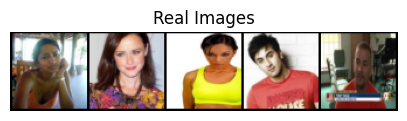

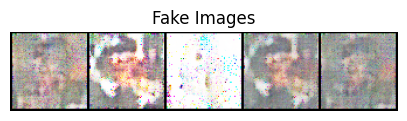

Epoch [17/50] | D Loss: 0.014346794225275517 | G Loss: 9.256427764892578


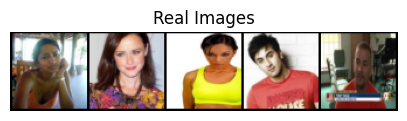

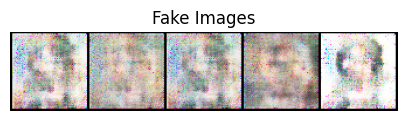

Epoch [18/50] | D Loss: 0.0002149971987819299 | G Loss: 10.621878623962402


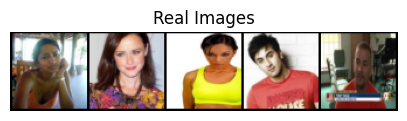

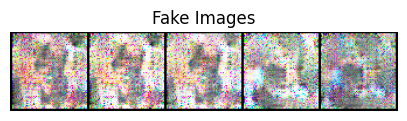

Epoch [19/50] | D Loss: 7.351400563493371e-05 | G Loss: 11.824731826782227


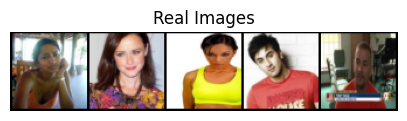

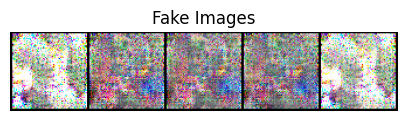

Epoch [20/50] | D Loss: 7.029403059277683e-05 | G Loss: 13.320099830627441


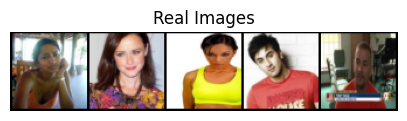

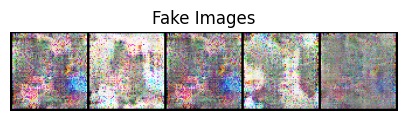

Epoch [21/50] | D Loss: 6.23274318058975e-05 | G Loss: 13.762144088745117


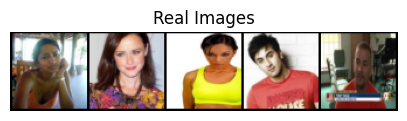

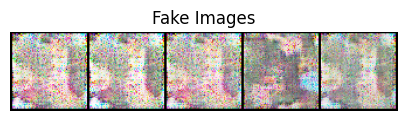

Epoch [22/50] | D Loss: 0.044441744685173035 | G Loss: 5.341835021972656


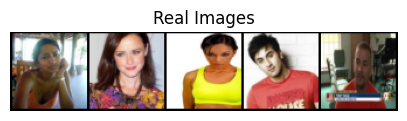

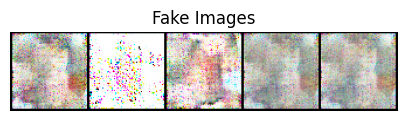

Epoch [23/50] | D Loss: 0.00026735858409665525 | G Loss: 8.637452125549316


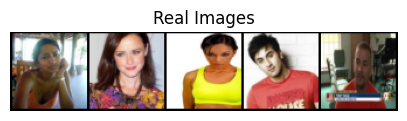

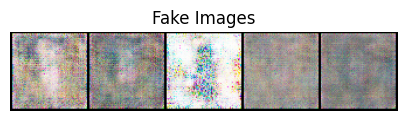

Epoch [24/50] | D Loss: 0.0004213605134282261 | G Loss: 11.433828353881836


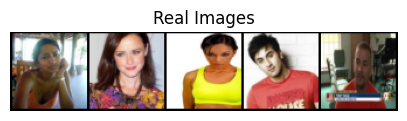

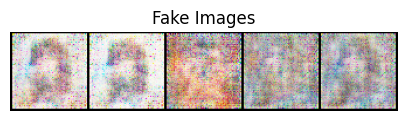

Epoch [25/50] | D Loss: 5.4082731367088854e-05 | G Loss: 19.526905059814453


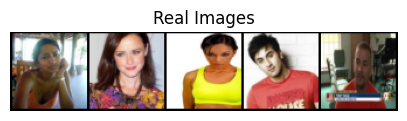

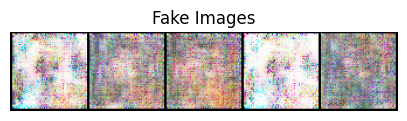

Epoch [26/50] | D Loss: 0.025549545884132385 | G Loss: 4.340428352355957


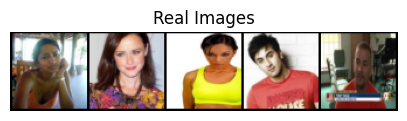

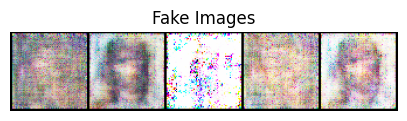

Epoch [27/50] | D Loss: 0.00026290398091077805 | G Loss: 12.154633522033691


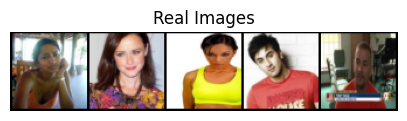

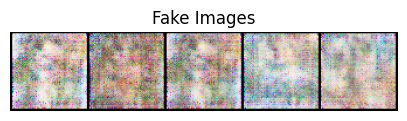

Epoch [28/50] | D Loss: 0.0001510686706751585 | G Loss: 10.708625793457031


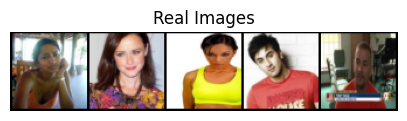

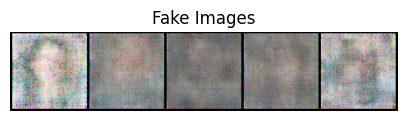

Epoch [29/50] | D Loss: 4.3614127207547426e-05 | G Loss: 11.118833541870117


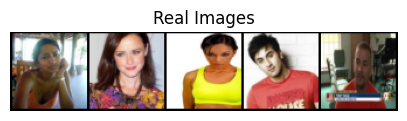

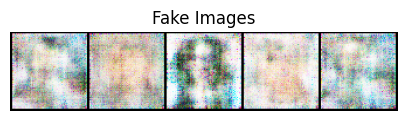

Epoch [30/50] | D Loss: 6.216484325705096e-05 | G Loss: 12.340524673461914


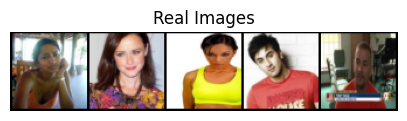

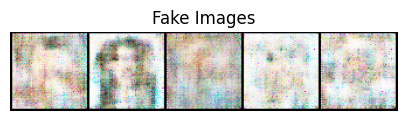

Epoch [31/50] | D Loss: 0.00018029229249805212 | G Loss: 9.531620025634766


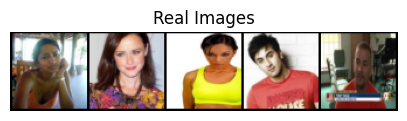

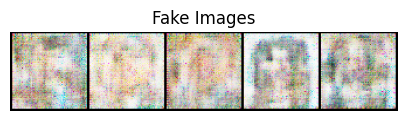

Epoch [32/50] | D Loss: 0.0007890406996011734 | G Loss: 27.516845703125


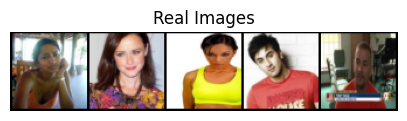

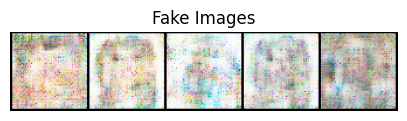

Epoch [33/50] | D Loss: 0.0001549194857943803 | G Loss: 16.158512115478516


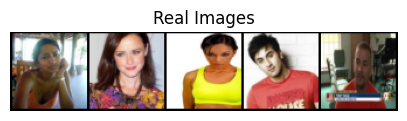

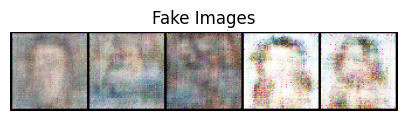

Epoch [34/50] | D Loss: 0.003176299389451742 | G Loss: 6.234271049499512


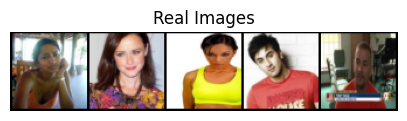

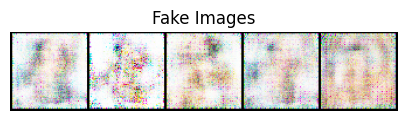

Epoch [35/50] | D Loss: 0.0002567482297308743 | G Loss: 9.703332901000977


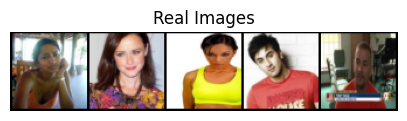

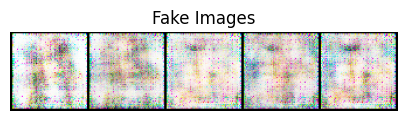

Epoch [36/50] | D Loss: 8.88702561496757e-06 | G Loss: 19.453086853027344


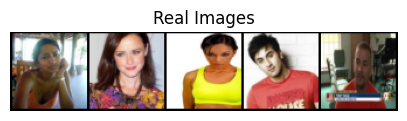

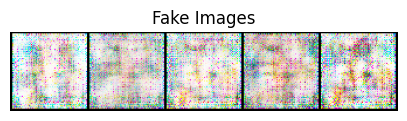

Epoch [37/50] | D Loss: 2.408466571068857e-05 | G Loss: 10.909819602966309


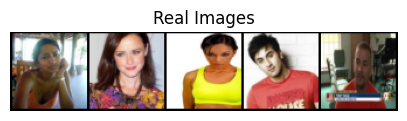

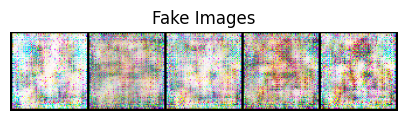

Epoch [38/50] | D Loss: 1.8930844589704066e-06 | G Loss: 17.791515350341797


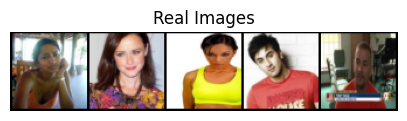

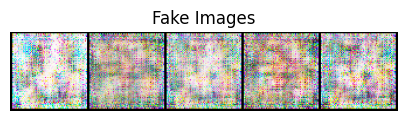

Epoch [39/50] | D Loss: 7.198469575087074e-06 | G Loss: 31.363441467285156


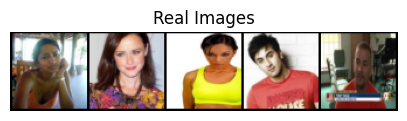

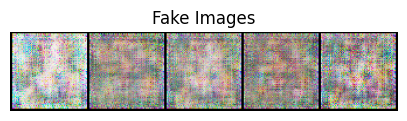

Epoch [40/50] | D Loss: 0.002377351513132453 | G Loss: 6.662261962890625


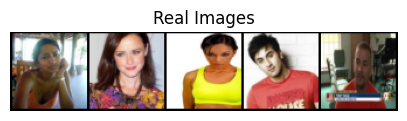

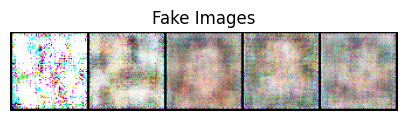

Epoch [41/50] | D Loss: 8.668027294334024e-05 | G Loss: 11.622871398925781


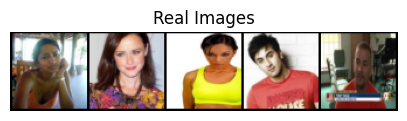

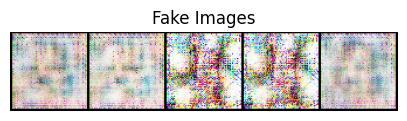

Epoch [42/50] | D Loss: 1.2300832167966291e-05 | G Loss: 15.211429595947266


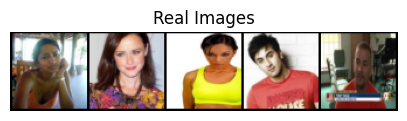

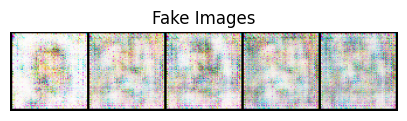

Epoch [43/50] | D Loss: 9.484314432484098e-06 | G Loss: 21.893001556396484


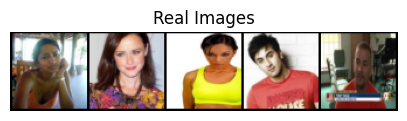

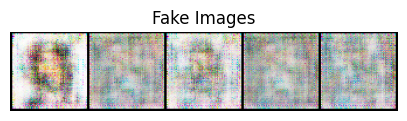

Epoch [44/50] | D Loss: 0.3999584913253784 | G Loss: 3.9687962532043457


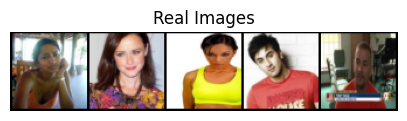

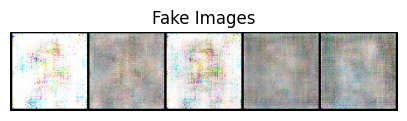

Epoch [45/50] | D Loss: 3.9661506889387965e-05 | G Loss: 13.324907302856445


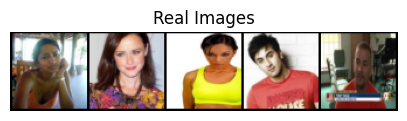

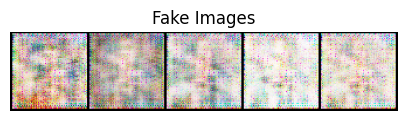

Epoch [46/50] | D Loss: 8.852633982314728e-06 | G Loss: 18.627307891845703


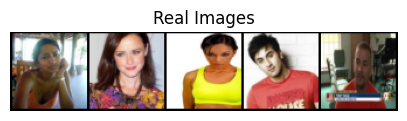

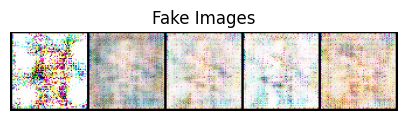

Epoch [47/50] | D Loss: 6.653234777331818e-06 | G Loss: 19.578325271606445


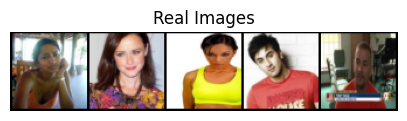

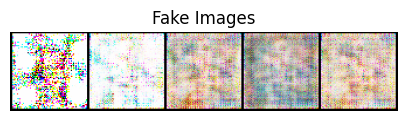

Epoch [48/50] | D Loss: 0.0018615152221173048 | G Loss: 8.932353973388672


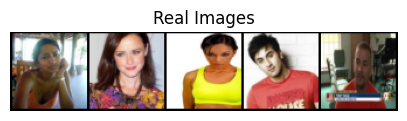

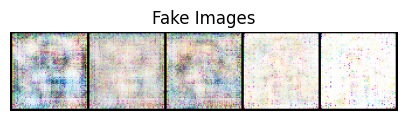

Epoch [49/50] | D Loss: 0.008841718547046185 | G Loss: 11.447240829467773


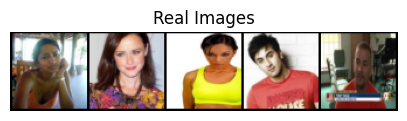

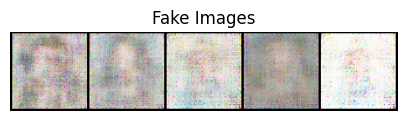

Epoch [50/50] | D Loss: 0.0006134946597740054 | G Loss: 7.772608280181885


In [14]:
import matplotlib.pyplot as plt

for epoch in range(epochs):
    for batch_idx, batch in enumerate(loaded_batches):
        if batch_idx < len(loaded_batches) - 1:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            noise = torch.randn(size=(batch_size, z_dim)).to(device)

            fake_labels = torch.zeros(size=(batch_size, 1)).to(device)
            real_labels = torch.ones(size=(batch_size, 1)).to(device)

            age_class_labels = labels[:, 0].long()
            gender_labels = labels[:, 1].long()
            ethnicity_labels = labels[:, 2].long()

            # Initialize the one-hot encoding tensor for the labels (size: batch_size x total_classes)
            labels_one_hot = torch.zeros((labels.size(0), 31)).to(device)

            # Fill in the one-hot labels:
            labels_one_hot[torch.arange(labels.size(0)), 24] = 1
            labels_one_hot[torch.arange(labels.size(0)), gender_labels + 24] = 1
            labels_one_hot[torch.arange(labels.size(0)), ethnicity_labels + 26] = 1

            labels = labels_one_hot.to(device)
            fake_images = generator(noise, labels)

            real_lossD = criterion(discriminator(images, labels), real_labels)
            fake_lossD = criterion(discriminator(fake_images.detach(), labels), fake_labels)
            lossD = (real_lossD + fake_lossD) / 2

            optim_disc.zero_grad()
            lossD.backward()
            optim_disc.step()

            lossG = criterion(discriminator(fake_images, labels), real_labels)
            optim_gen.zero_grad()
            lossG.backward()
            optim_gen.step()

            if batch_idx == 0:
                # Generate grid of real and fake images
                real_images_grid = vutils.make_grid(images[:5], nrow=5, normalize=True)
                fake_images_grid = vutils.make_grid(fake_images[:5], nrow=5, normalize=True)

                # Plot real images
                plt.figure(figsize=(5,5))
                plt.imshow(real_images_grid.permute(1, 2, 0).cpu().numpy())
                plt.title('Real Images')
                plt.axis('off')
                plt.show()

                # Plot fake images
                plt.figure(figsize=(5, 5))
                plt.imshow(fake_images_grid.permute(1, 2, 0).cpu().numpy())
                plt.title('Fake Images')
                plt.axis('off')
                plt.show()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {lossD.item()} | G Loss: {lossG.item()}")
